### Ordinal Regression - binary crossentropy + metrics=['accuracy']
### Fine tuning weights
### Oversampling 3x 4 + 4x 5

In [1]:
from keras.engine import Model
from keras.layers import Flatten, Dense, Input, Dropout
from keras_vggface.vggface import VGGFace
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface import utils
from keras.optimizers import Adam
from keras.preprocessing import image
from PIL import Image
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils import class_weight
import keras
import random, string
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import scipy.misc
%matplotlib inline

/home/gloria/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/gloria/tensorflow/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Constants
IMG_SIZE = 200

IMG_DIR = '../project/all_females_combined_oversampled_train_s'
RATING_PATH = '../project/all_females_combined_oversampled_train_s/train_ratings.txt'

VAL_IMG_DIR = '../project/all_females_combined_val_s'
VAL_RATING_PATH = '../project/all_females_combined_val_s/val_ratings.txt'

SAVE_AUG_TRAIN_PATH = '../project/all_females_AUG_2_combined_oversampled_train_s'

if not os.path.isdir(SAVE_AUG_TRAIN_PATH):
    os.makedirs(SAVE_AUG_TRAIN_PATH)

VERSION = 'v6-val-oversampled'

In [3]:
def getMean(train_data):
    #calculate mean values for pixels (RGB)
    mean = np.zeros(3)
    for i in train_data:
        _img = image.load_img(os.path.join(IMG_DIR, i), target_size=(IMG_SIZE,IMG_SIZE))
        _x = image.img_to_array(_img)
        mean[0] += _x[:,:,0].sum() / _x.shape[0] * _x.shape[1] #divide by number of pixels in image
        mean[1] += _x[:,:,1].sum() / _x.shape[0] * _x.shape[1]
        mean[2] += _x[:,:,2].sum() / _x.shape[0] * _x.shape[1]
    #divide by number of images
    print(mean[0])
    mean = mean / train_data.shape[0]
    return mean

In [4]:
def preprocess(x, mean):
    print(x.shape)

In [5]:
def prepareData(percentage):
    # Load ratings
    ratings = np.genfromtxt(RATING_PATH)
    
    # Convert ratings to the desired format
    # 1. First round them
    ratings_rounded = np.round(ratings, 1).astype(np.int8)

    # 2. Then encode as suggested by Cheng (2007)
    ratings_prepared = np.zeros((len(ratings_rounded), len(np.unique(ratings_rounded)))).astype(np.int8)
    for i, r in enumerate(ratings_rounded):
        for j in range(r):
            ratings_prepared[i, j] = 1
        
    # 3. Finally, make sure assignment is correct
    assert np.all(np.sum(ratings_prepared, axis=1).astype(np.int8) == ratings_rounded)
    
    ### Move all images according to ratings
    images = sorted(os.listdir(IMG_DIR))
    #remove train_ratings.txt from images
    images.remove('train_ratings.txt')
    #convert to np.array for indexing
    images = np.array(images)

    ### Make sure lengths of ratings and images correspond 
    print(len(ratings))
    print(len(images))
    assert len(ratings) == len(images)
    
    perm_ratings = np.random.permutation(len(ratings))
    test_len = int(len(ratings) * percentage/100)
    train_len = len(ratings) - test_len

    test_ind = perm_ratings[:test_len]
    train_ind = perm_ratings[test_len:]
    
    #test_ind = test_ind.astype(np.int8)
    #print(train_ind)# = train_ind.astype(np.int8)
    
    #get test & train data
    data_test = np.zeros((len(test_ind), IMG_SIZE, IMG_SIZE, 3))    
    data_train = np.zeros((len(train_ind), IMG_SIZE, IMG_SIZE, 3)) 
    last_set_train = 0
    last_set_test = 0
    
    #mean = getMean(images[train_ind])
    #print(mean)
    
    for idx, _im in enumerate(images): #iterate over images
        if idx in test_ind:
            _img = image.load_img(os.path.join(IMG_DIR, _im), target_size=(IMG_SIZE,IMG_SIZE))
            _x = image.img_to_array(_img)
            _x = np.expand_dims(_x, axis=0)
            data_test[last_set_test, :, :, :] = utils.preprocess_input(_x, version=1) #/ .255
            last_set_test += 1
        if idx in train_ind:
            _img = image.load_img(os.path.join(IMG_DIR, _im), target_size=(IMG_SIZE,IMG_SIZE))
            _x = image.img_to_array(_img)
            _x = np.expand_dims(_x, axis=0)
            data_train[last_set_train, :, :, :] = utils.preprocess_input(_x, version=1) #/ .255
            last_set_train += 1
    

    return data_train, ratings_prepared[train_ind], data_test, ratings_prepared[test_ind], ratings_rounded, images[train_ind]

In [6]:
def getGenerator(data_train, data_test):
    train_datagen = ImageDataGenerator(rescale=1./255, 
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest',
                                preprocessing_function=None)#utils.preprocess_input)

    train_datagen.fit(data_train)
    
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen.fit(data_test)

    return train_datagen, test_datagen

In [7]:
def visualize_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(15,8))
    plt.plot(epochs, loss, 'bo-', label="Training loss")
    plt.plot(epochs, val_loss, 'b', label="Validation loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [8]:
def visualize_acc(history):
    loss = history.history['acc']
    val_loss = history.history['val_acc']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(15,8))
    plt.plot(epochs, loss, 'ro-', label="Training acc")
    plt.plot(epochs, val_loss, 'r', label="Validation acc")
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend()
    plt.show()

In [9]:
def recommend(images, pred_classes):
    recs = np.where(pred_classes >= 4)
    
    for i in recs[0]:
        img = mpimg.imread(os.path.join(IMG_DIR, images[i]))
        imgplot = plt.imshow(img)
        plt.show()
        plt.clf()

def recommendVal(images, pred_classes):
    recs = np.where(pred_classes >= 4)
    
    for i in recs[0]:
        img = mpimg.imread(os.path.join(VAL_IMG_DIR, images[i]))
        imgplot = plt.imshow(img)
        plt.show()
        plt.clf()

In [10]:
x_train, y_train, x_test, y_test, ratings, images = prepareData(5)
train_generator, test_generator = getGenerator(x_train,x_test)

1127
1127


In [11]:
print(x_train.shape)
print(x_test.shape)

(1071, 200, 200, 3)
(56, 200, 200, 3)


In [12]:
# Add custom layers
vgg_base = VGGFace(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), pooling='max')
last_layer = vgg_base.get_layer('global_max_pooling2d_1').output
X = Dense(256, activation='relu', name='fc6')(last_layer)
X = Dropout(0.2)(X)
X = Dense(128, activation='relu', name='fc7')(X)
X = Dropout(0.2)(X)
X = Dense(64, activation='relu', name='fc8')(X)
X = Dropout(0.2)(X)
output = Dense(len(np.unique(ratings)), activation='sigmoid')(X)
model = Model(inputs=vgg_base.input, outputs=output)

# Freeze vgg layers
for layer in vgg_base.layers:
    layer.trainable = False
    
# Compute class weights since we have unbalaned classes
class_weight = class_weight.compute_class_weight('balanced', 
                                                 np.unique(ratings), 
                                                 ratings)

# give even more weight to classes 4 and 5, since we are interested in those
#if len(class_weight) == 6:
#    class_weight[-1] *= 2
#    class_weight[-2] *= 2
#elif len(class_weight) == 5:
    #no ratings with class 5
#    class_weight[-1] *= 2

model.compile(optimizer=Adam(lr= 0.0001,clipnorm=1.0),
              loss='binary_crossentropy', 
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='./weights-' + VERSION + '.hdf5', verbose=1, save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=0)

In [13]:
epochs = 20
filenames = []

for e in range(epochs):
    print('Epoch', e)
    batches = 0
    for x_batch, y_batch in train_generator.flow(x_train, y_train, batch_size=32):
        for x_batch_test, y_batch_test in test_generator.flow(x_test, y_test, batch_size=32):
            model.fit(x_batch, y_batch, class_weight=class_weight, validation_data=(x_batch_test, y_batch_test), callbacks=[earlystop, checkpointer])
            break
        #save augmented data
        for x,y in zip(x_batch,y_batch):
            name = ''.join(random.choices(string.ascii_uppercase + string.digits, k=5))
            while name in filenames: #make sure we don't overwrite any images
                name = ''.join(random.choices(string.ascii_uppercase + string.digits, k=5))
            scipy.misc.imsave(SAVE_AUG_TRAIN_PATH + '/' + name + '.jpg', x)
            with open(SAVE_AUG_TRAIN_PATH + '/ratings.txt', 'a') as f:
                f.write(str(y.sum(axis=-1)) + '\n')
        batches += 1
        if batches >= len(x_train) / 32:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

Epoch 0
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 4s 128ms/step - loss: 0.6887 - acc: 0.5521 - val_loss: 0.6674 - val_acc: 0.6510

Epoch 00001: val_loss improved from inf to 0.66741, saving model to ./weights-v6-val-oversampled.hdf5
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 22ms/step - loss: 0.6699 - acc: 0.6302 - val_loss: 0.6601 - val_acc: 0.7135

Epoch 00001: val_loss improved from 0.66741 to 0.66012, saving model to ./weights-v6-val-oversampled.hdf5
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 20ms/step - loss: 0.6761 - acc: 0.5938 - val_loss: 0.6623 - val_acc: 0.6927

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.6514 - acc: 0.7031 - val_loss: 0.6581 - val_acc: 0.7292

Epoch 00001: val_loss improved from 0.66012 t

Train on 15 samples, validate on 32 samples
Epoch 1/1
15/15 [==============================] - 2s 128ms/step - loss: 0.5308 - acc: 0.7444 - val_loss: 0.5222 - val_acc: 0.7760

Epoch 00001: val_loss did not improve
Epoch 1
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 20ms/step - loss: 0.5082 - acc: 0.7656 - val_loss: 0.4994 - val_acc: 0.7812

Epoch 00001: val_loss improved from 0.50293 to 0.49941, saving model to ./weights-v6-val-oversampled.hdf5
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.5552 - acc: 0.7083 - val_loss: 0.5112 - val_acc: 0.7604

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4908 - acc: 0.7708 - val_loss: 0.5143 - val_acc: 0.7500

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==========


Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 20ms/step - loss: 0.4445 - acc: 0.7604 - val_loss: 0.4551 - val_acc: 0.7448

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4769 - acc: 0.7396 - val_loss: 0.4574 - val_acc: 0.7344

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4691 - acc: 0.7812 - val_loss: 0.4703 - val_acc: 0.7188

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4334 - acc: 0.7917 - val_loss: 0.5047 - val_acc: 0.7031

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step -

Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 22ms/step - loss: 0.4758 - acc: 0.7656 - val_loss: 0.4889 - val_acc: 0.6667

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4258 - acc: 0.7865 - val_loss: 0.5028 - val_acc: 0.7031

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.5278 - acc: 0.7396 - val_loss: 0.4667 - val_acc: 0.7083

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.5017 - acc: 0.7656 - val_loss: 0.4631 - val_acc: 0.7500

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4757 - acc: 0.7396 - val_loss:

32/32 [==============================] - 1s 21ms/step - loss: 0.5307 - acc: 0.7500 - val_loss: 0.4433 - val_acc: 0.7500

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4541 - acc: 0.7812 - val_loss: 0.4500 - val_acc: 0.7760

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4537 - acc: 0.7760 - val_loss: 0.4515 - val_acc: 0.7188

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.5244 - acc: 0.7083 - val_loss: 0.4468 - val_acc: 0.7396

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 20ms/step - loss: 0.4545 - acc: 0.7760 - val_loss: 0.4721 - val_acc: 0.7135

Epoch 00001: val_loss did n


Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.5125 - acc: 0.7292 - val_loss: 0.4669 - val_acc: 0.7240

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 20ms/step - loss: 0.5061 - acc: 0.7552 - val_loss: 0.4946 - val_acc: 0.7135

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4845 - acc: 0.7760 - val_loss: 0.4821 - val_acc: 0.7188

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 22ms/step - loss: 0.4736 - acc: 0.7760 - val_loss: 0.4731 - val_acc: 0.7240

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step -

Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4754 - acc: 0.7448 - val_loss: 0.4612 - val_acc: 0.7344

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.5482 - acc: 0.7188 - val_loss: 0.4843 - val_acc: 0.7135

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4218 - acc: 0.8125 - val_loss: 0.4728 - val_acc: 0.7396

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4911 - acc: 0.7083 - val_loss: 0.4889 - val_acc: 0.6719

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4283 - acc: 0.8073 - val_loss:

32/32 [==============================] - 1s 21ms/step - loss: 0.4519 - acc: 0.8177 - val_loss: 0.5040 - val_acc: 0.6823

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4714 - acc: 0.7500 - val_loss: 0.4904 - val_acc: 0.7135

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4706 - acc: 0.7344 - val_loss: 0.4318 - val_acc: 0.7552

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.5098 - acc: 0.7344 - val_loss: 0.4958 - val_acc: 0.6927

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4709 - acc: 0.7240 - val_loss: 0.4495 - val_acc: 0.7604

Epoch 00001: val_loss did n


Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.5091 - acc: 0.7396 - val_loss: 0.4475 - val_acc: 0.7292

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 22ms/step - loss: 0.4453 - acc: 0.7708 - val_loss: 0.4761 - val_acc: 0.7135

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.5276 - acc: 0.7812 - val_loss: 0.4725 - val_acc: 0.7083

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.3809 - acc: 0.8281 - val_loss: 0.4465 - val_acc: 0.7396

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step -

32/32 [==============================] - 1s 21ms/step - loss: 0.4696 - acc: 0.7292 - val_loss: 0.4660 - val_acc: 0.7188

Epoch 00001: val_loss did not improve
Train on 15 samples, validate on 32 samples
Epoch 1/1
15/15 [==============================] - 0s 33ms/step - loss: 0.5590 - acc: 0.6778 - val_loss: 0.4538 - val_acc: 0.7448

Epoch 00001: val_loss did not improve
Epoch 10
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4638 - acc: 0.7656 - val_loss: 0.4646 - val_acc: 0.6979

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4417 - acc: 0.7656 - val_loss: 0.4332 - val_acc: 0.7552

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.5281 - acc: 0.7656 - val_loss: 0.5056 - val_acc: 0.7031

Epoch 00001: val_l


Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4970 - acc: 0.7344 - val_loss: 0.4966 - val_acc: 0.6979

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4618 - acc: 0.7604 - val_loss: 0.4056 - val_acc: 0.7448

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 22ms/step - loss: 0.4533 - acc: 0.7760 - val_loss: 0.4568 - val_acc: 0.7188

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.5041 - acc: 0.7135 - val_loss: 0.4663 - val_acc: 0.7292

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 20ms/step -

32/32 [==============================] - 1s 21ms/step - loss: 0.4347 - acc: 0.8177 - val_loss: 0.4660 - val_acc: 0.7240

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 20ms/step - loss: 0.3987 - acc: 0.7656 - val_loss: 0.4262 - val_acc: 0.7396

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4475 - acc: 0.7812 - val_loss: 0.4924 - val_acc: 0.6979

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4653 - acc: 0.7760 - val_loss: 0.4926 - val_acc: 0.6979

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4586 - acc: 0.7188 - val_loss: 0.4923 - val_acc: 0.7135

Epoch 00001: val_loss did n


Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4666 - acc: 0.8125 - val_loss: 0.4321 - val_acc: 0.7552

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4115 - acc: 0.7969 - val_loss: 0.4530 - val_acc: 0.7604

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4269 - acc: 0.7552 - val_loss: 0.4431 - val_acc: 0.7396

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 20ms/step - loss: 0.4515 - acc: 0.7865 - val_loss: 0.4738 - val_acc: 0.7031

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 22ms/step -

32/32 [==============================] - 1s 21ms/step - loss: 0.4889 - acc: 0.7760 - val_loss: 0.5050 - val_acc: 0.6771

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4627 - acc: 0.7292 - val_loss: 0.4669 - val_acc: 0.7135

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4590 - acc: 0.7760 - val_loss: 0.5092 - val_acc: 0.6667

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4844 - acc: 0.7917 - val_loss: 0.4220 - val_acc: 0.7448

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4741 - acc: 0.7396 - val_loss: 0.4482 - val_acc: 0.7448

Epoch 00001: val_loss did n


Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4659 - acc: 0.7656 - val_loss: 0.4375 - val_acc: 0.7396

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 20ms/step - loss: 0.4518 - acc: 0.7969 - val_loss: 0.4624 - val_acc: 0.7135

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4513 - acc: 0.7917 - val_loss: 0.4659 - val_acc: 0.7031

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 22ms/step - loss: 0.4582 - acc: 0.8021 - val_loss: 0.5076 - val_acc: 0.6667

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step -

32/32 [==============================] - 1s 21ms/step - loss: 0.4329 - acc: 0.8177 - val_loss: 0.4689 - val_acc: 0.7188

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.3959 - acc: 0.8073 - val_loss: 0.4752 - val_acc: 0.7083

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4565 - acc: 0.7344 - val_loss: 0.4949 - val_acc: 0.6823

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4539 - acc: 0.7760 - val_loss: 0.4198 - val_acc: 0.7500

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4792 - acc: 0.7656 - val_loss: 0.4486 - val_acc: 0.7448

Epoch 00001: val_loss did n


Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4606 - acc: 0.7396 - val_loss: 0.5095 - val_acc: 0.6875

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 22ms/step - loss: 0.4748 - acc: 0.7656 - val_loss: 0.4318 - val_acc: 0.7240

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4179 - acc: 0.8021 - val_loss: 0.4863 - val_acc: 0.6823

Epoch 00001: val_loss did not improve
Train on 15 samples, validate on 32 samples
Epoch 1/1
15/15 [==============================] - 0s 33ms/step - loss: 0.4120 - acc: 0.7667 - val_loss: 0.4719 - val_acc: 0.7240

Epoch 00001: val_loss did not improve
Epoch 18
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21

32/32 [==============================] - 1s 21ms/step - loss: 0.4198 - acc: 0.7812 - val_loss: 0.4816 - val_acc: 0.7031

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4718 - acc: 0.8073 - val_loss: 0.4439 - val_acc: 0.7188

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4133 - acc: 0.8594 - val_loss: 0.4636 - val_acc: 0.7292

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4380 - acc: 0.7760 - val_loss: 0.4402 - val_acc: 0.7344

Epoch 00001: val_loss did not improve
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 1s 21ms/step - loss: 0.4232 - acc: 0.7552 - val_loss: 0.4789 - val_acc: 0.6875

Epoch 00001: val_loss did n

In [14]:
history = model.evaluate(x_test, y_test)

56/56 [==============================] - 3s 48ms/step


In [15]:
print(history)

[4.252136843545096, 0.7202380980764117]


In [16]:
#visualize_acc(history)

In [17]:
model.save('./models/love_classifier' + VERSION + '.h5')

In [18]:
predictions = model.predict(x_test)
print(predictions.shape)
pred_classes = predictions.sum(axis=-1)
pred_classes = np.round(pred_classes, 1).astype(np.int8)
print(pred_classes.shape)

y_true = np.array(y_test).sum(axis=-1).astype(np.int8)
print(y_true)
print(pred_classes)

confusion_matrix(y_true,pred_classes)

(56, 6)
(56,)
[4 2 3 4 2 4 4 1 0 4 4 1 5 1 2 1 0 4 1 1 4 5 3 4 5 0 2 4 1 4 1 2 1 0 0 1 2
 2 3 1 4 1 4 0 4 4 4 4 4 4 1 1 2 5 2 1]
[4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4
 3 3 4 4 4 4 4 3 4 4 3 3 4 4 3 3 3 4 4]


array([[ 0,  0,  0,  0,  6,  0],
       [ 0,  0,  0,  1, 14,  0],
       [ 0,  0,  0,  3,  6,  0],
       [ 0,  0,  0,  1,  2,  0],
       [ 0,  0,  0,  4, 15,  0],
       [ 0,  0,  0,  1,  3,  0]])

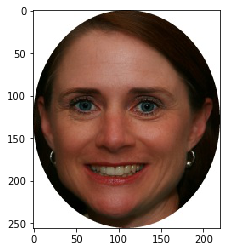

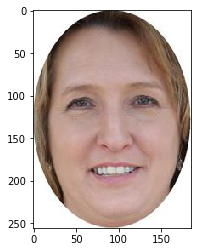

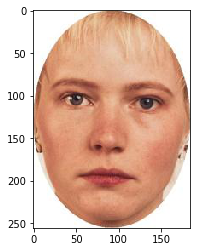

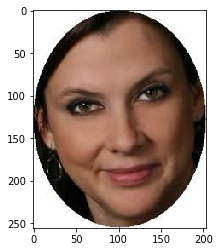

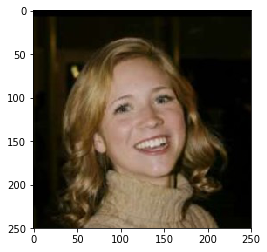

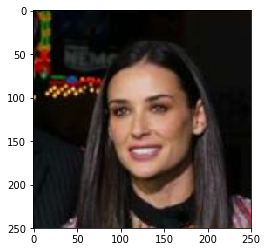

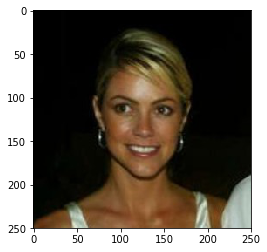

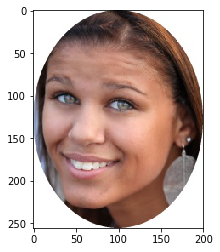

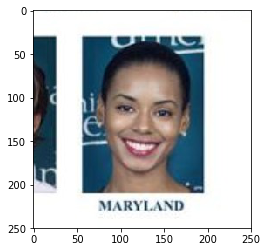

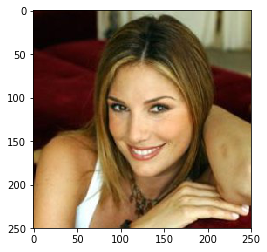

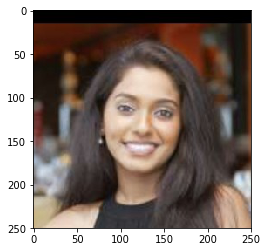

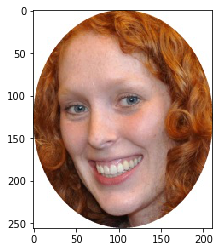

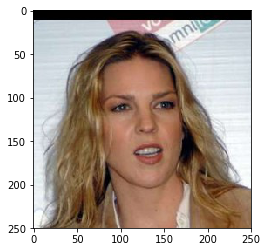

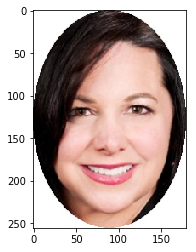

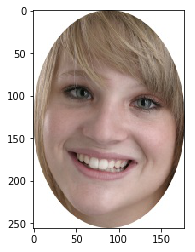

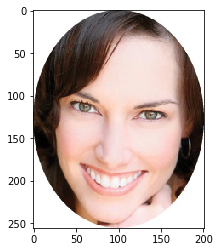

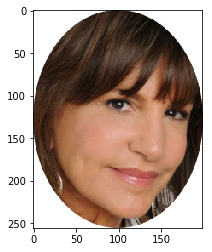

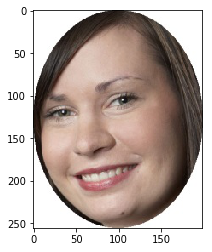

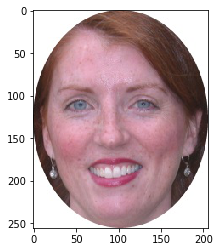

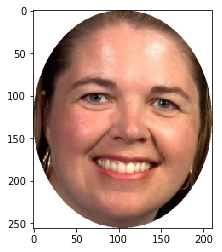

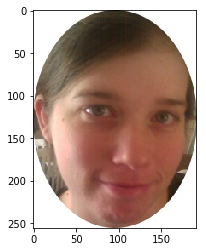

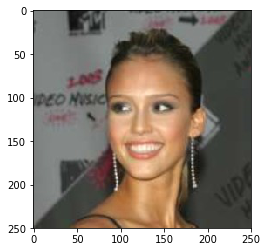

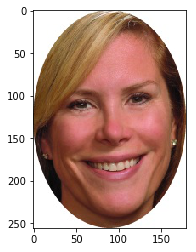

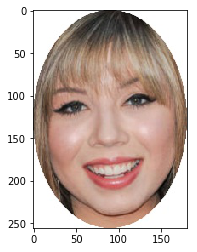

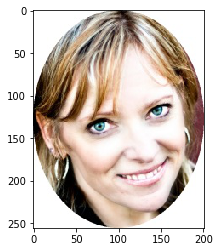

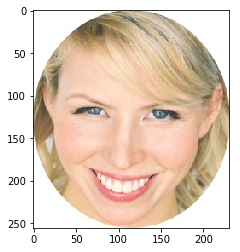

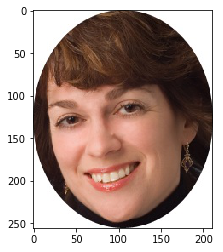

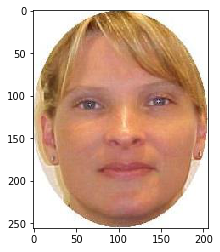

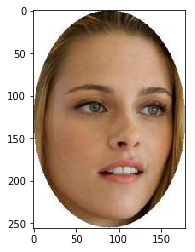

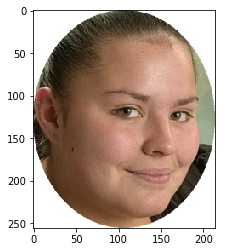

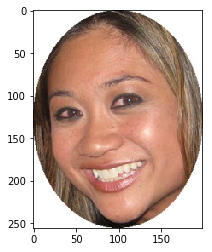

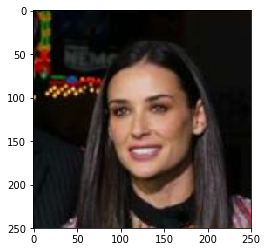

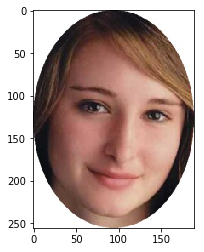

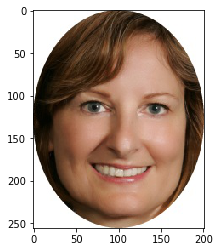

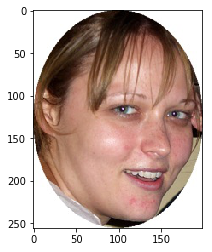

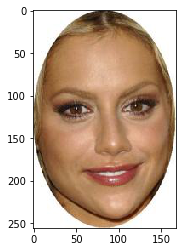

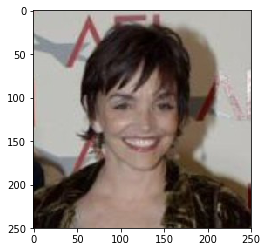

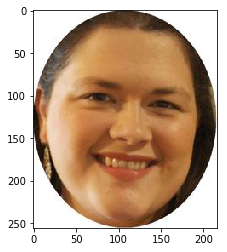

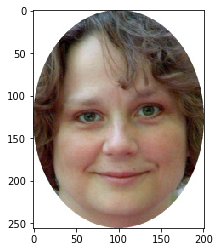

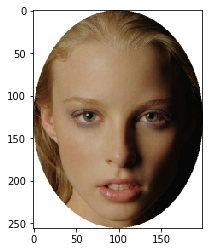

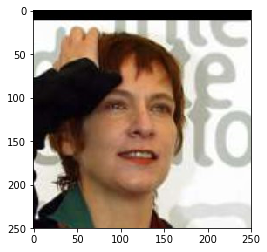

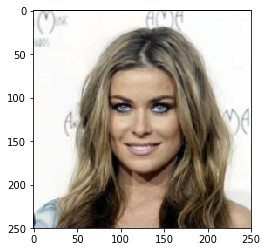

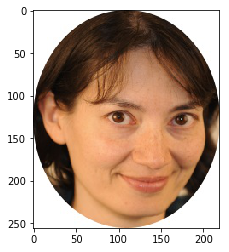

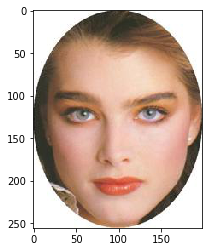

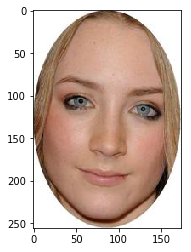

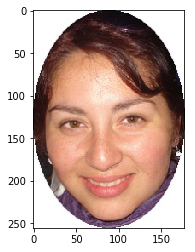

In [19]:
recommend(images,pred_classes)

### Validation

In [20]:
def prepareValData():
    # Load ratings
    ratings = np.genfromtxt(VAL_RATING_PATH)
    
    # Convert ratings to the desired format
    # 1. First round them
    ratings_rounded = np.round(ratings, 1).astype(np.int8)

    # 2. Then encode as suggested by Cheng (2007)
    ratings_prepared = np.zeros((len(ratings_rounded), len(np.unique(ratings_rounded))))
    for i, r in enumerate(ratings_rounded):
        for j in range(r):
            ratings_prepared[i, j] = 1
        
    # 3. Finally, make sure assignment is correct
    assert np.all(np.sum(ratings_prepared, axis=1).astype(np.int8) == ratings_rounded)
    
    ### Move all images according to ratings
    images = sorted(os.listdir(VAL_IMG_DIR))
    #remove val_ratings.txt from images
    images.remove('val_ratings.txt')
    #convert for indexing
    images = np.array(images)

    ### Make sure lengths of ratings and images correspond 
    assert len(ratings) == len(images)
    
    data = np.zeros((len(images), IMG_SIZE, IMG_SIZE, 3)) 
    last_set = 0
    
    for idx, _im in enumerate(images): #iterate over images
        _img = image.load_img(os.path.join(VAL_IMG_DIR, _im), target_size=(IMG_SIZE,IMG_SIZE))
        _x = image.img_to_array(_img)
        _x = np.expand_dims(_x, axis=0)
        data[last_set, :, :, :] = utils.preprocess_input(_x, version=1) / 255
        last_set += 1
    
    return data, ratings, images

In [21]:
x_val, ratings_val, images = prepareValData()

predictions = model.predict(x_val)
pred_classes = predictions.sum(axis=-1)
pred_classes = np.round(pred_classes, 1).astype(np.int8)

y_true = np.array(ratings_val).astype(np.int8)
print(y_true)
print(pred_classes)

confusion_matrix(y_true,pred_classes)

[0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 3 3 3 3 3 3 3 4 4 4 4 4 4 4 5 5]
[3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 3 2 2 2 2 3 2 2 2 2 2 2 2]


array([[0, 0, 6, 1, 0, 0],
       [0, 0, 7, 0, 0, 0],
       [0, 0, 6, 1, 0, 0],
       [0, 0, 6, 1, 0, 0],
       [0, 0, 6, 1, 0, 0],
       [0, 0, 2, 0, 0, 0]])

In [22]:
recommendVal(images,pred_classes)

### !! For the test set it only predicts 3s and 4s but for the val set it predicts only 2s and 3s

### Predict seperately

In [23]:
for idx,x in enumerate(x_val):
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    pred_classes = predictions.sum(axis=-1)
    pred_classes = np.round(pred_classes, 1).astype(np.int8)
    
    y_true = np.array(ratings_val[idx]).astype(np.int8)
    print("Pred: ", pred_classes)
    print("True: ", y_true)
    print("-----------------")

Pred:  [3]
True:  0
-----------------
Pred:  [2]
True:  0
-----------------
Pred:  [2]
True:  0
-----------------
Pred:  [2]
True:  0
-----------------
Pred:  [2]
True:  0
-----------------
Pred:  [2]
True:  0
-----------------
Pred:  [2]
True:  0
-----------------
Pred:  [2]
True:  1
-----------------
Pred:  [2]
True:  1
-----------------
Pred:  [2]
True:  1
-----------------
Pred:  [2]
True:  1
-----------------
Pred:  [2]
True:  1
-----------------
Pred:  [2]
True:  1
-----------------
Pred:  [2]
True:  1
-----------------
Pred:  [2]
True:  2
-----------------
Pred:  [3]
True:  2
-----------------
Pred:  [2]
True:  2
-----------------
Pred:  [2]
True:  2
-----------------
Pred:  [2]
True:  2
-----------------
Pred:  [2]
True:  2
-----------------
Pred:  [2]
True:  2
-----------------
Pred:  [2]
True:  3
-----------------
Pred:  [2]
True:  3
-----------------
Pred:  [2]
True:  3
-----------------
Pred:  [3]
True:  3
-----------------
Pred:  [2]
True:  3
-----------------
Pred:  [2]
T

### No difference